--2023-10-23 06:48:04--  https://www.fit.vutbr.cz/study/courses/ISS/public/NEW_PRED/11_sampling/bell-ringing-01c.wav
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4897924 (4.7M) [audio/x-wav]
Saving to: ‘bell-ringing-01c.wav’

bell-ringing-01c.wa 100%[===================>]   4.67M  1.57MB/s    in 3.0s    

2023-10-23 06:48:09 (1.57 MB/s) - ‘bell-ringing-01c.wav’ saved [4897924/4897924]

--2023-10-23 06:48:09--  https://www.fit.vutbr.cz/study/courses/ISS/public/NEW_PRED/11_sampling/prase.wav
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21506 (21K) [audio/x-wav]
Saving to: ‘prase.wav’

prase.wav           100%[===================

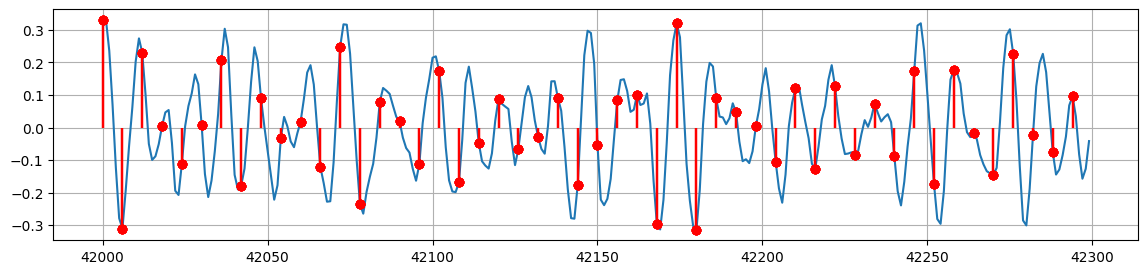

In [ ]:
# ================= ISS: changing sampling frequency
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import spectrogram, lfilter, freqz, tf2zpk
from matplotlib import cm

from IPython.display import Audio
from IPython.display import display

!wget https://www.fit.vutbr.cz/study/courses/ISS/public/NEW_PRED/11_sampling/bell-ringing-01c.wav
!wget https://www.fit.vutbr.cz/study/courses/ISS/public/NEW_PRED/11_sampling/prase.wav

# >>>>>>>>>>>>>>>>> #downsampling_wrong <<<<<<<<<<<<<<<<<<<<<<<<<
s, Fs = sf.read('bell-ringing-01c.wav')    # stereo, select only 2 secs ...
x = s[:,0] + s[:,1]
x = x[0:2*Fs]
n = np.arange(x.size)
display(Audio(x, rate=Fs))
nshow = np.arange(42000,42300)

# down-sampling
DSfactor = 6
nselect = np.arange(0,x.size,DSfactor)
nselect_show = (nshow / 6).astype(int)
xds = x[nselect]
Fsds = Fs / DSfactor
#print(x.size, xds.size)
display(Audio(xds, rate=Fs/DSfactor))

# visualization
plt.figure(figsize=(14,3))
plt.plot(nshow, x[nshow])
plt.stem(nselect_show * 6, xds[nselect_show],basefmt=" ",linefmt='r',markerfmt='ro')
plt.gca().grid()


In [ ]:
# >>>>>>>>>>>>>>>>> #downsampling_spectra <<<<<<<<<<<<<<<<<<<<<<<<<

def plot_spectrogram(f, t, sgr, name='', vmin=-160, ax=None):
    # Transfer to PSD
    sgr_log = 10 * np.log10(sgr + 1e-20)  # log(0) is undefined -> +1e-20 (add small value)

    if ax == None:
        fig = plt.figure(figsize=(20, 6))
        ax = fig.add_subplot(111)

    name = f'[{name}]' if name else ''
    ax.set_title("Spectogram " + name, pad=10)
    ax.set_xlabel('$t\ [s]$')
    ax.set_ylabel('$f\ [Hz]$', rotation=0, labelpad=42)
    ax.set_xlim(min(t), max(t))

    # pcolormesh of spectogram:
    cmesh = ax.pcolormesh(t, f, sgr_log, shading="gouraud", cmap=cm.inferno, vmin=vmin)
    cbar = plt.colorbar(cmesh, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('PSD\n$[dB]$', rotation=0, labelpad=30)
    plt.tight_layout()

# setting specgram parameters
lensec = 0.01  # standard centi-second
nfft = 1024
nperseg=int(lensec * Fs)
npersegds=int(lensec * Fsds)
noverlap=0

freq, time, sgr = spectrogram(x, Fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Original 48kHz')
# let us zoom on frequencies from 0 to 4kHz
fzoom = freq[freq < 4000]
sgrzoom = sgr[:fzoom.size,:]
plot_spectrogram(fzoom, time, sgrzoom, name='zoom Original 48kHz from 0 to 4 KHz')

freq, time, sgr = spectrogram(xds, Fsds, nperseg=npersegds, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Downsampled 8kHz')


Output hidden; open in https://colab.research.google.com to view.

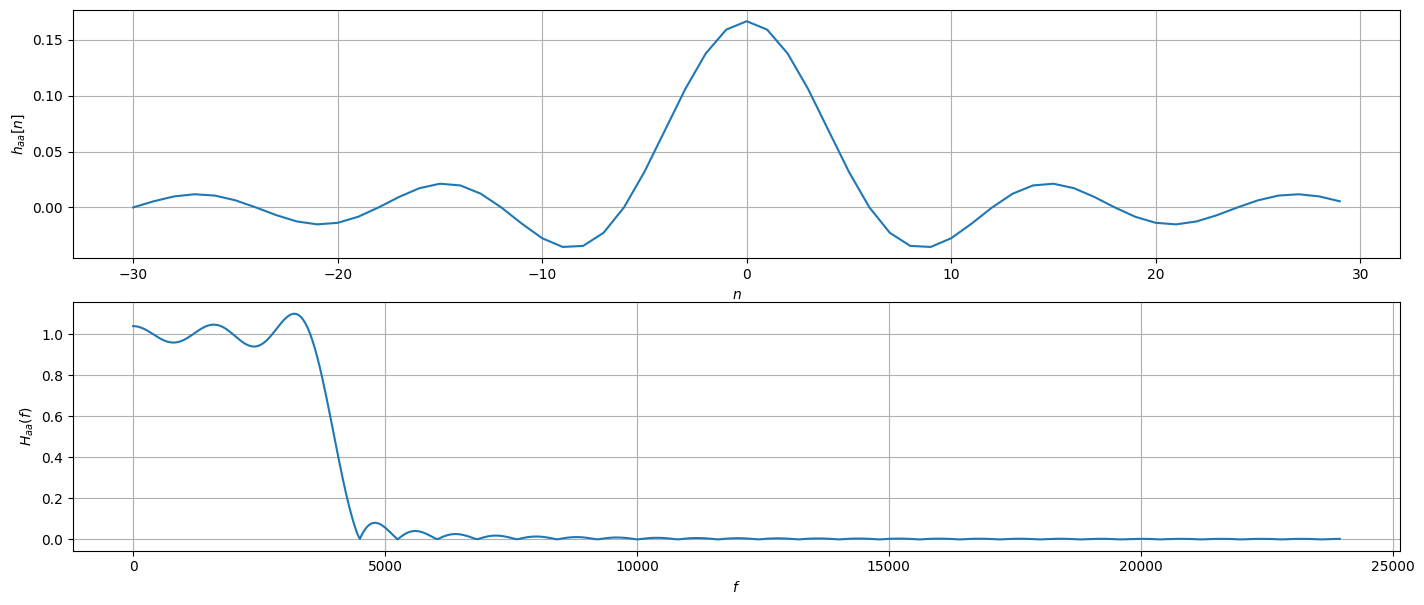

In [ ]:
# >>>>>>>>>>>>>>>>> #aa_filter <<<<<<<<<<<<<<<<<<<<<<<<<
nfilter = np.arange(-5*DSfactor,5*DSfactor)
h = np.sinc(nfilter / DSfactor * np.pi / np.pi)
h = h / DSfactor
fig, ax = plt.subplots(2,1,figsize=(14,6))
fig.tight_layout()
ax[0].plot(nfilter,h)
ax[0].set_xlabel('$n$')
ax[0].set_ylabel('$h_{aa}[n]$')
ax[0].grid()

f, H = freqz(h, 1, fs = Fs)
ax[1].plot(f, np.abs(H))
ax[1].set_xlabel('$f$')
ax[1].set_ylabel('$H_{aa}(f)$')
ax[1].grid()


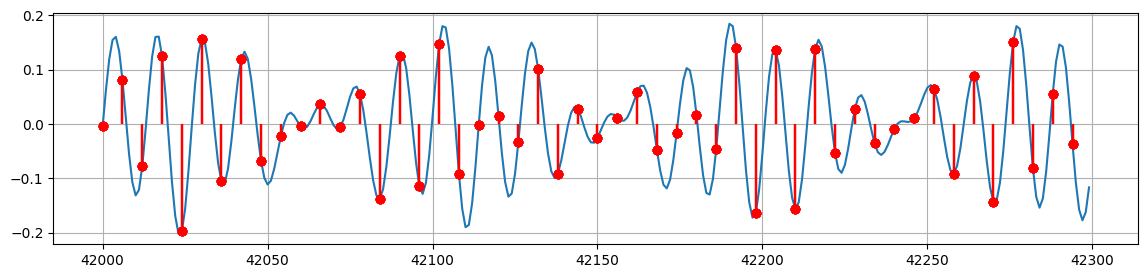

In [ ]:
# >>>>>>>>>>>>>>>>> #downsampling_aa_solved <<<<<<<<<<<<<<<<<<<<<<<<<
xaa = lfilter(h,1,x)
xaads = xaa[nselect]

# visualization
plt.figure(figsize=(14,3))
plt.plot(nshow, xaa[nshow])
plt.stem(nselect_show * 6, xaads[nselect_show],basefmt=" ",linefmt='r',markerfmt='ro')
plt.gca().grid()

display(Audio(x, rate=Fs))
display(Audio(xds, rate=Fs / DSfactor))
display(Audio(xaa, rate=Fs))
display(Audio(xaads, rate=Fs / DSfactor))


In [ ]:
# >>>>>>>>>>>>>>>>> #downsampling_aa_solved_spectra <<<<<<<<<<<<<<<<<<<<<<<<<
# includes also zooms ...
freq, time, sgr = spectrogram(x, Fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Original 48kHz')
fzoom = freq[freq < 4000]
plot_spectrogram(fzoom, time, sgr[:fzoom.size,:], name='zoom Original 48kHz from 0 to 4 KHz')

freq, time, sgr = spectrogram(xaa, Fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Original 48kHz with AA filter applied')
fzoom = freq[freq < 4000]
plot_spectrogram(fzoom, time, sgr[:fzoom.size,:], name='zoom Original 48kHz with AA filter applied from 0 to 4 KHz')

freq, time, sgr = spectrogram(xds, Fsds, nperseg=npersegds, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Downsampled 8kHz')
freq, time, sgr = spectrogram(xaads, Fsds, nperseg=npersegds, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='AA filter applied and downsampled 8kHz')


Output hidden; open in https://colab.research.google.com to view.

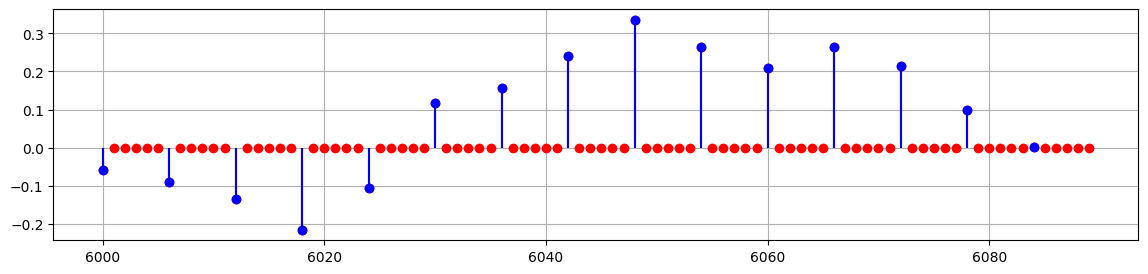

In [ ]:
# >>>>>>>>>>>>>>>>> #upsampling_zero_fill <<<<<<<<<<<<<<<<<<<<<<<<<
x, Fs = sf.read('prase.wav')
n = np.arange(x.size)
display(Audio(x, rate=Fs))
nshow = np.arange(1000,1015)

# up-sampling
USfactor = 6
xus = np.zeros(x.size * USfactor)
nselect = np.arange(0,x.size * DSfactor,DSfactor)
xus[nselect] = x
nshow_us = np.arange(DSfactor*1000,DSfactor*1015)
Fsus = Fs * DSfactor
#print(x.size, xds.size)
display(Audio(xus, rate=Fsus))

# visualization
plt.figure(figsize=(14,3))
plt.stem(nshow_us, xus[nshow_us],basefmt=" ",linefmt='r',markerfmt='ro')
plt.stem(nshow * 6, x[nshow],basefmt=" ",linefmt='b',markerfmt='bo')
plt.gca().grid()


In [ ]:
# >>>>>>>>>>>>>>>>> #upsampling_zero_fill_spectra <<<<<<<<<<<<<<<<<<<<<<<<<
# setting specgram parameters
lensec = 0.01  # standard centi-second
nfft = 1024
nperseg=int(lensec * Fs)
npersegus=int(lensec * Fsus)
noverlap=0

freq, time, sgr = spectrogram(x, Fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Original 8kHz')

freq, time, sgr = spectrogram(xus, Fsus, nperseg=npersegus, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Up-sampled 48kHz, filling with zeros')


Output hidden; open in https://colab.research.google.com to view.

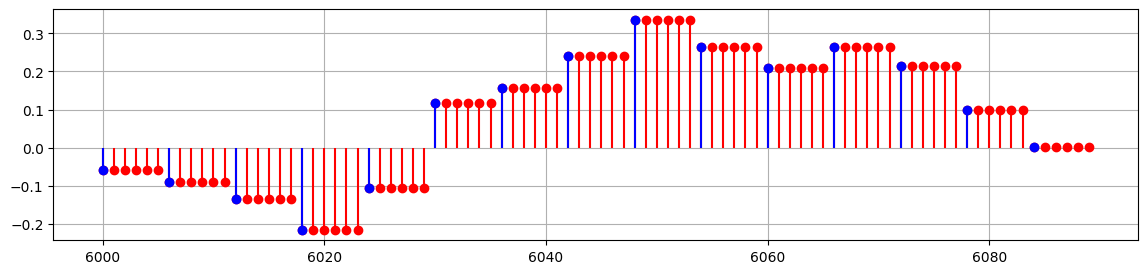

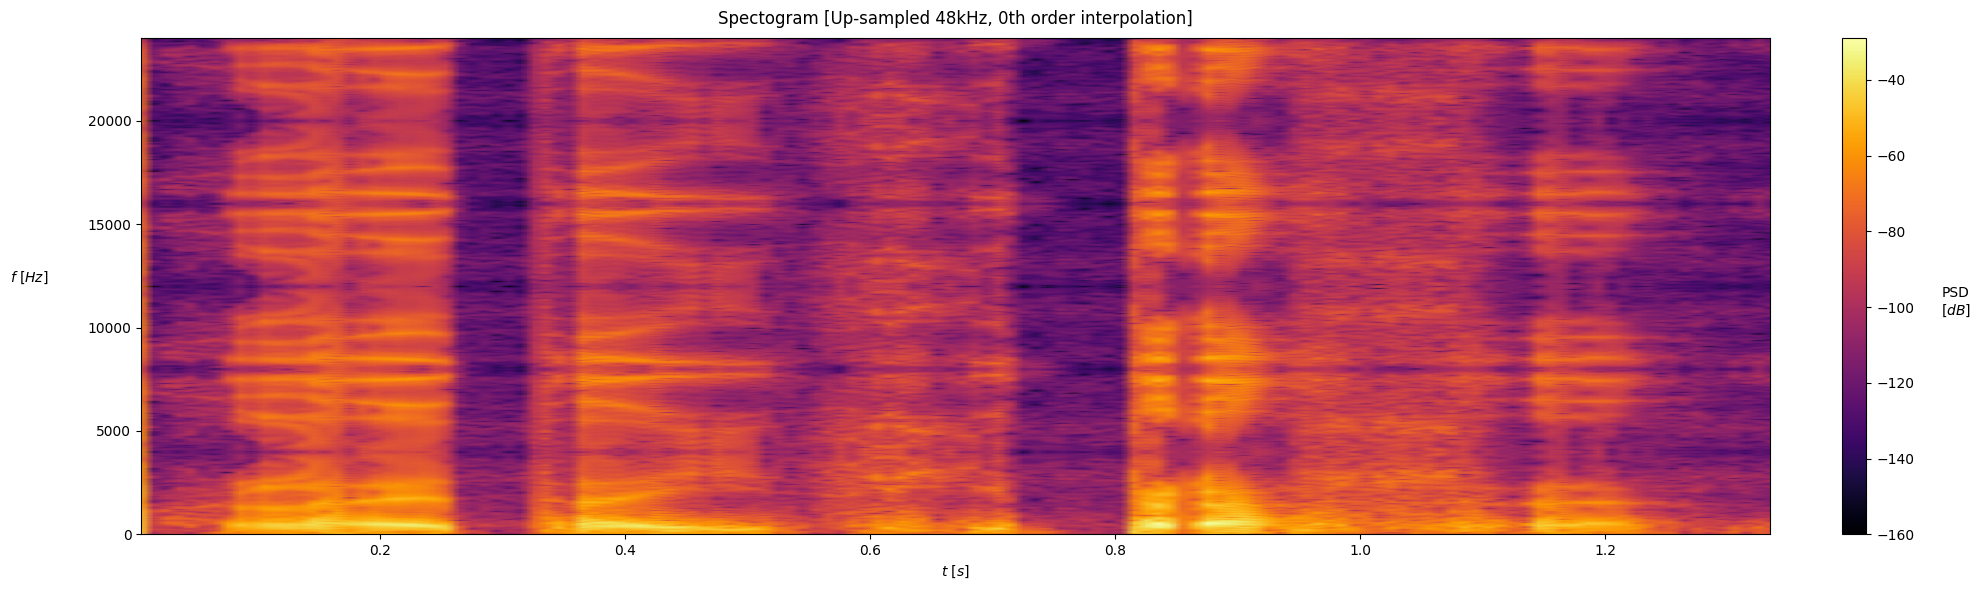

In [ ]:
# >>>>>>>>>>>>>>>>> #upsampling_steps <<<<<<<<<<<<<<<<<<<<<<<<<
display(Audio(x, rate=Fs))

# up-sampling
USfactor = 6
xus = np.repeat(x,USfactor)
display(Audio(xus, rate=Fsus))

# visualization
plt.figure(figsize=(14,3))
plt.stem(nshow_us, xus[nshow_us],basefmt=" ",linefmt='r',markerfmt='ro')
plt.stem(nshow * 6, x[nshow],basefmt=" ",linefmt='b',markerfmt='bo')
plt.gca().grid()

#spectra
freq, time, sgr = spectrogram(xus, Fsus, nperseg=npersegus, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Up-sampled 48kHz, 0th order interpolation')

[0.16666667 0.33333333 0.5        0.66666667 0.83333333 1.
 0.83333333 0.66666667 0.5        0.33333333 0.16666667]


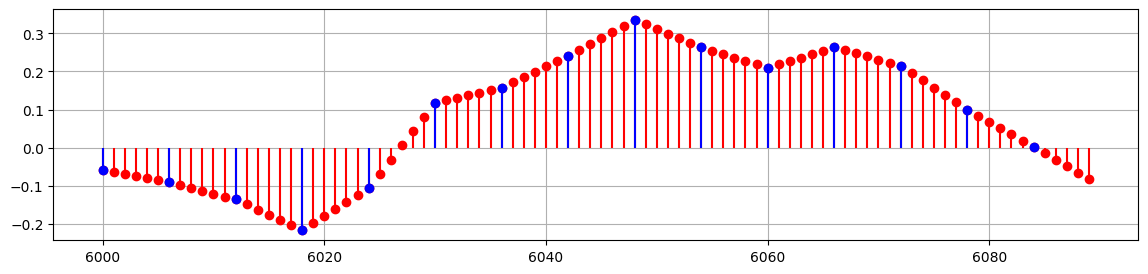

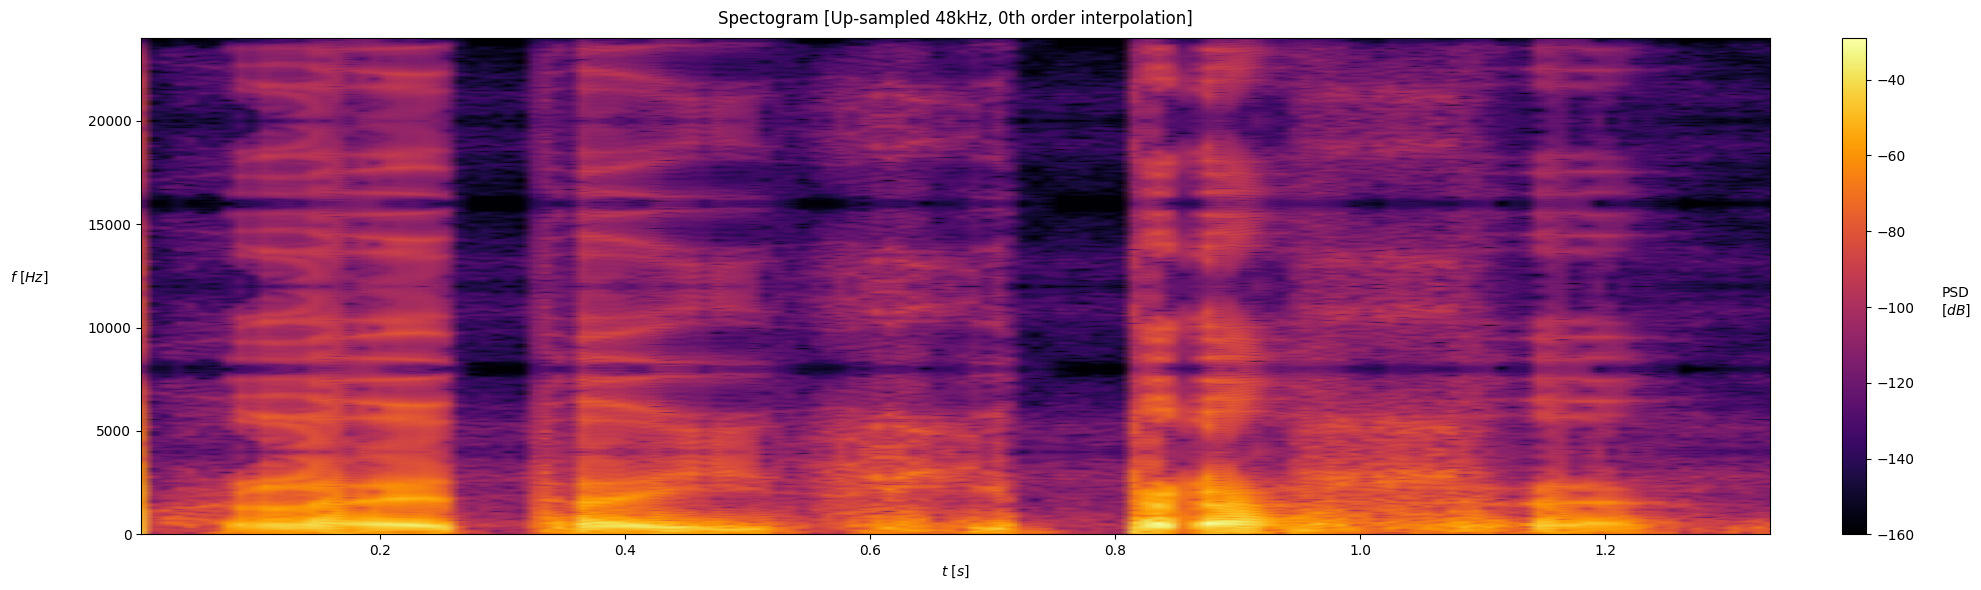

In [ ]:
# >>>>>>>>>>>>>>>>> #upsampling_lines <<<<<<<<<<<<<<<<<<<<<<<<<
USfactor = 6
hline = np.linspace(0,1,7)
hline = np.concatenate((hline[1:],hline[-2:0:-1]))
print(hline)

xus = np.zeros(x.size * USfactor)
nselect = np.arange(0,x.size * DSfactor,DSfactor)
xus[nselect] = x
xus = lfilter(hline,1,xus)      # good but the result is delayed ...
xus = xus[5:]
display(Audio(x, rate=Fs))
display(Audio(xus, rate=Fsus))

# visualization
plt.figure(figsize=(14,3))
plt.stem(nshow_us, xus[nshow_us],basefmt=" ",linefmt='r',markerfmt='ro')
plt.stem(nshow * 6, x[nshow],basefmt=" ",linefmt='b',markerfmt='bo')
plt.gca().grid()

#spectra
freq, time, sgr = spectrogram(xus, Fsus, nperseg=npersegus, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Up-sampled 48kHz, 0th order interpolation')

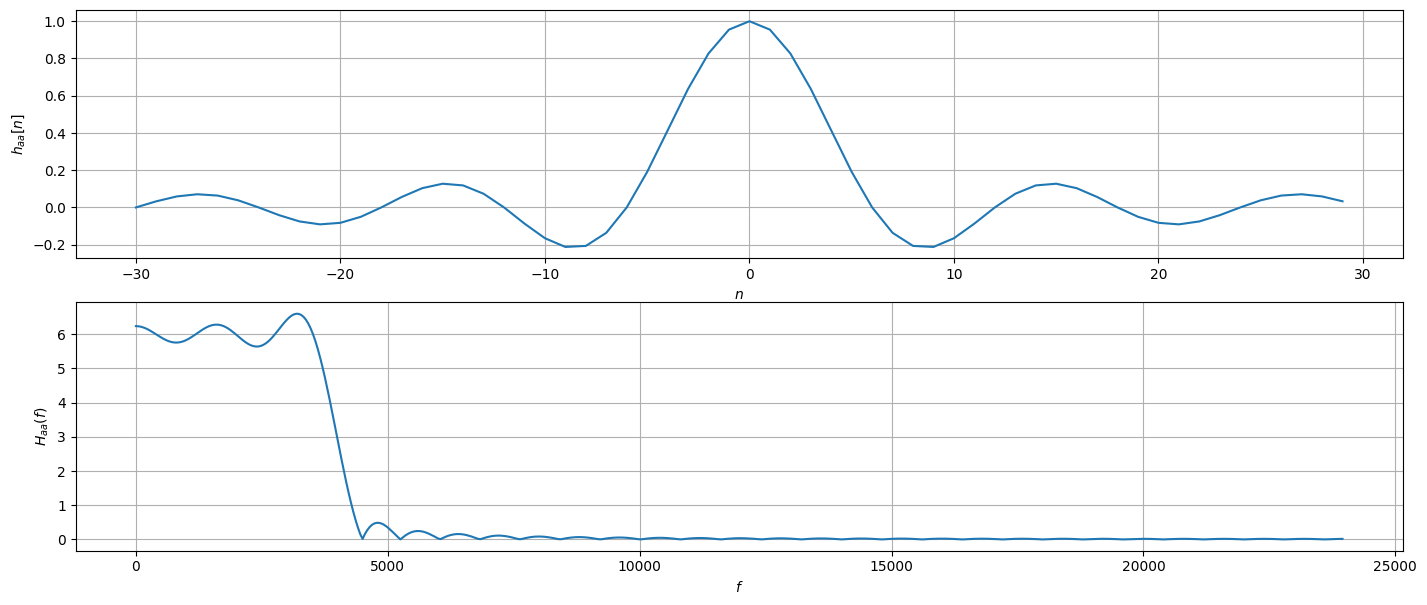

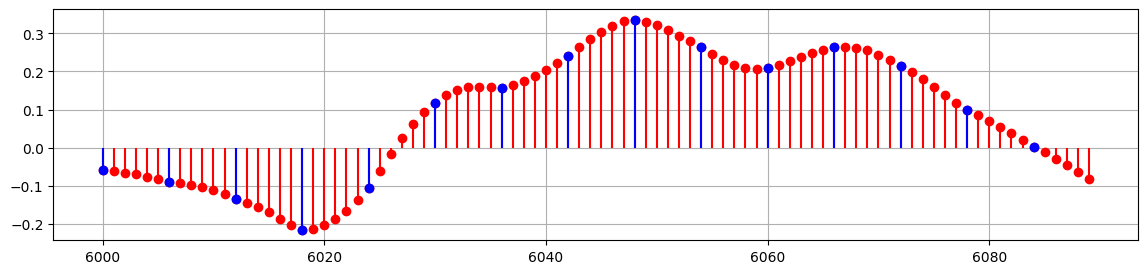

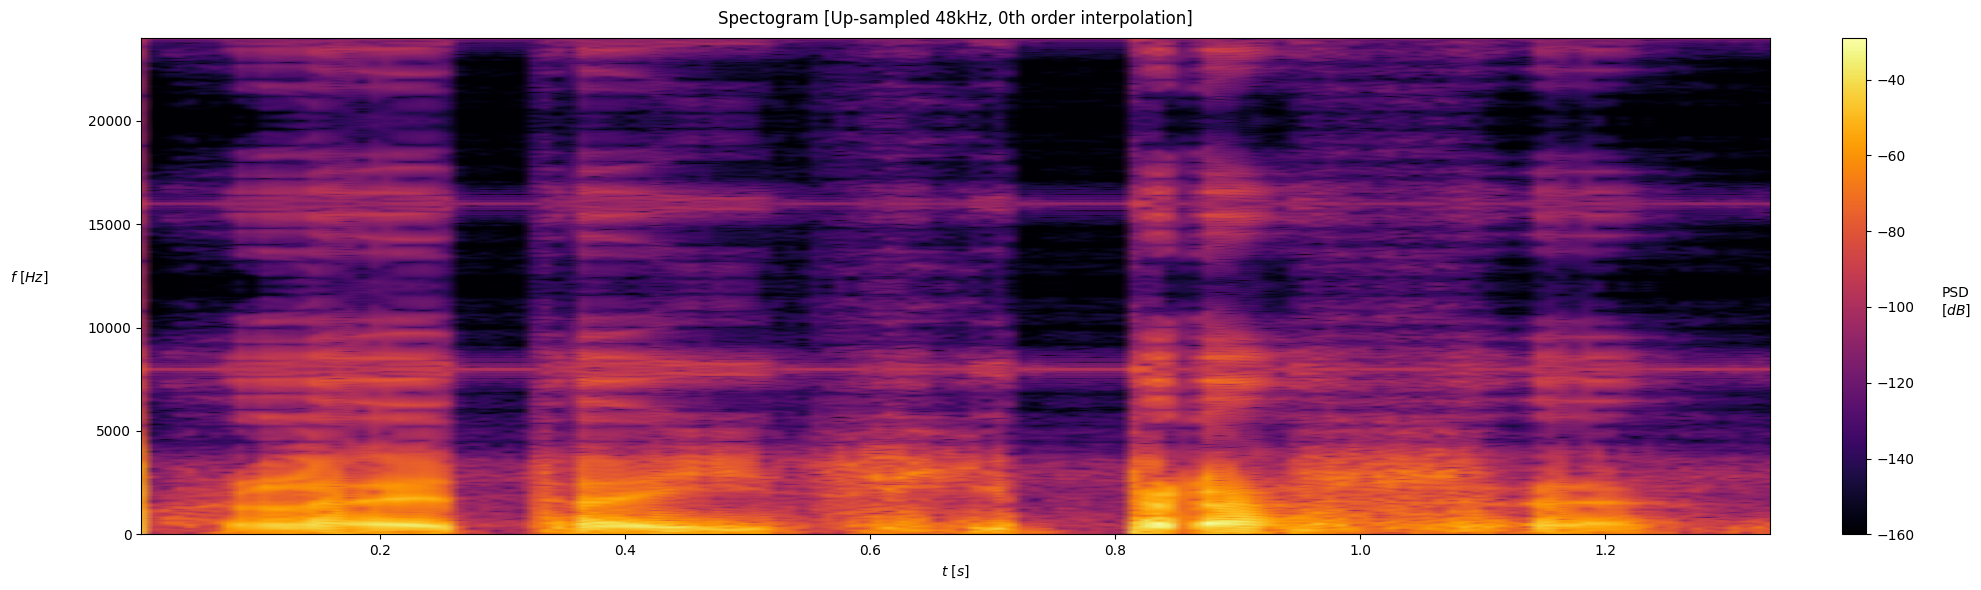

In [ ]:
# >>>>>>>>>>>>>>>>> #upsampling_correct <<<<<<<<<<<<<<<<<<<<<<<<<
USfactor = 6
LOBES = 5     # <--- length of reconstruction filter can be set here.

nfilter = np.arange(-LOBES*DSfactor,LOBES*DSfactor)
h = np.sinc(nfilter / USfactor * np.pi / np.pi)
#h = h * USfactor
fig, ax = plt.subplots(2,1,figsize=(14,6))
fig.tight_layout()
ax[0].plot(nfilter,h)
ax[0].set_xlabel('$n$')
ax[0].set_ylabel('$h_{aa}[n]$')
ax[0].grid()

f, H = freqz(h, 1, fs = Fsus)
ax[1].plot(f, np.abs(H))
ax[1].set_xlabel('$f$')
ax[1].set_ylabel('$H_{aa}(f)$')
ax[1].grid()

xus = np.zeros(x.size * USfactor)
nselect = np.arange(0,x.size * DSfactor,DSfactor)
xus[nselect] = x
xus = lfilter(h,1,xus)      # good but the result is delayed ...
xus = xus[LOBES*DSfactor:]
display(Audio(x, rate=Fs))
display(Audio(xus, rate=Fsus))

# visualization
plt.figure(figsize=(14,3))
plt.stem(nshow_us, xus[nshow_us],basefmt=" ",linefmt='r',markerfmt='ro')
plt.stem(nshow * 6, x[nshow],basefmt=" ",linefmt='b',markerfmt='bo')
plt.gca().grid()

#spectra
freq, time, sgr = spectrogram(xus, Fsus, nperseg=npersegus, noverlap=noverlap, nfft=nfft)
plot_spectrogram(freq, time, sgr, name='Up-sampled 48kHz, 0th order interpolation')